In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures




# Store results
regression_results = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine_Learning/Mini_Project/sy.csv')

df = df.sort_values('arrival_time').reset_index(drop=True)

# Select Features & Target
cat_feats = ['mode_of_arrival', 'chief_complaint', 'age_bucket']
num_feats = [
    'triage_level','age','hour_of_day','day_of_week',
    'hour_sin','hour_cos','dow_sin','dow_cos','is_weekend',
    'is_ambulance','triage_x_age','triage_x_ambulance',
    'arrivals_last_60m','is_busy_period'
]

X = df[cat_feats + num_feats]
y = df['service_time']

In [ ]:
# Train-Test Split (Time-Based)
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('num', StandardScaler(), num_feats)
    ]
)

## Checking Assumptions

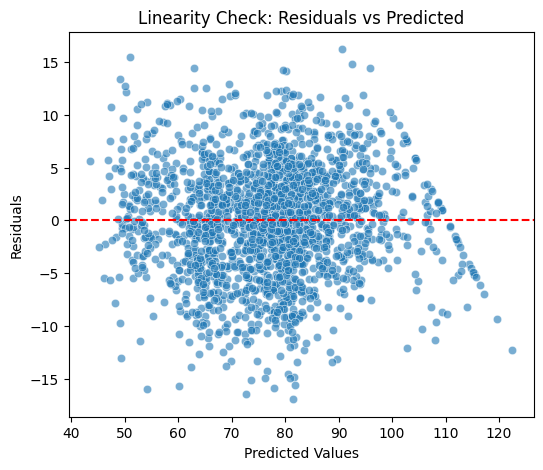

In [ ]:
# Linearity: Residuals vs Predicted

# Fit a temporary model for residual analysis
temp_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])
temp_model.fit(X_train, y_train)
y_pred_temp = temp_model.predict(X_test)
residuals = y_test - y_pred_temp

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred_temp, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Linearity Check: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Linearity:

The residuals vs predicted values plot shows a fairly random scatter around the zero line,
indicating that the relationship between features and target variable is approximately linear.
There is no clear curved or funnel-shaped trend, suggesting the linearity assumption holds.

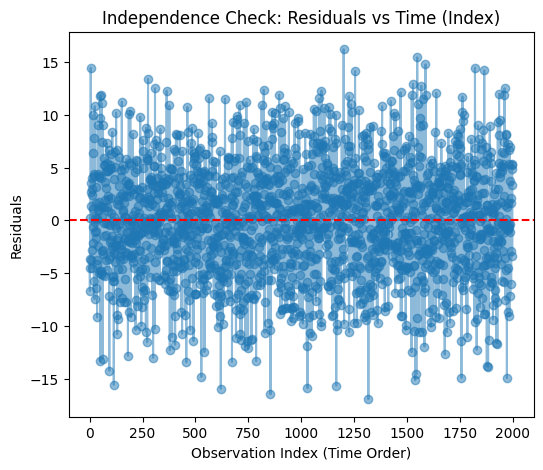

In [ ]:
# Independence: Residuals vs Time

plt.figure(figsize=(6,5))
plt.plot(residuals.values, marker='o', alpha=0.5)
plt.title("Independence Check: Residuals vs Time (Index)")
plt.xlabel("Observation Index (Time Order)")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Independence:

The residuals vs time plot does not display any strong sequential pattern or systematic trend.
The residuals oscillate randomly around zero, implying independence across observations.
Hence, there is no significant autocorrelation present in the residuals.

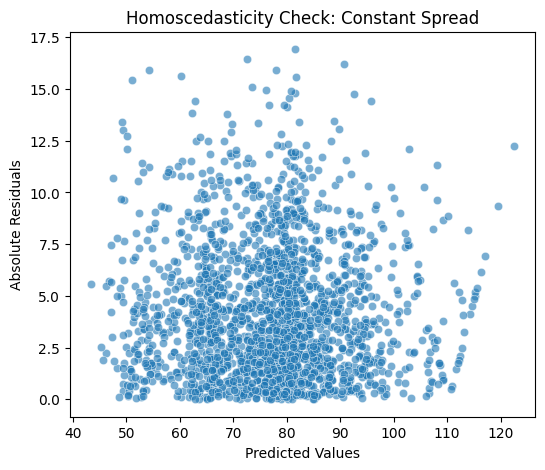

In [ ]:
# Homoscedasticity: Residuals vs Predicted

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred_temp, y=np.abs(residuals), alpha=0.6)
plt.title("Homoscedasticity Check: Constant Spread")
plt.xlabel("Predicted Values")
plt.ylabel("Absolute Residuals")
plt.show()

Homoscedasticity:

The residual spread appears fairly consistent across predicted values,
although some variation exists at the higher end.
Overall, the constant variance assumption (homoscedasticity) is reasonably satisfied.

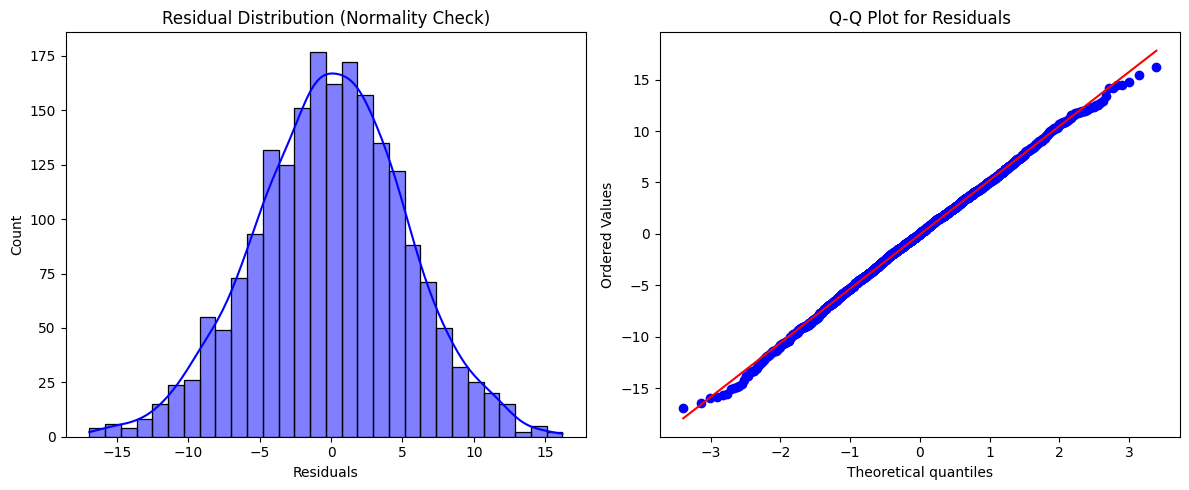

In [ ]:
# Normality of Residuals

plt.figure(figsize=(12,5))

# Histogram + KDE
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residual Distribution (Normality Check)")
plt.xlabel("Residuals")

# Q-Q Plot
plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.tight_layout()
plt.show()

Normality:

The histogram of residuals (with KDE curve) roughly resembles a bell-shaped curve.
While minor deviations are present at the tails, the distribution is approximately normal.

The normality assumption is reasonably satisfied.

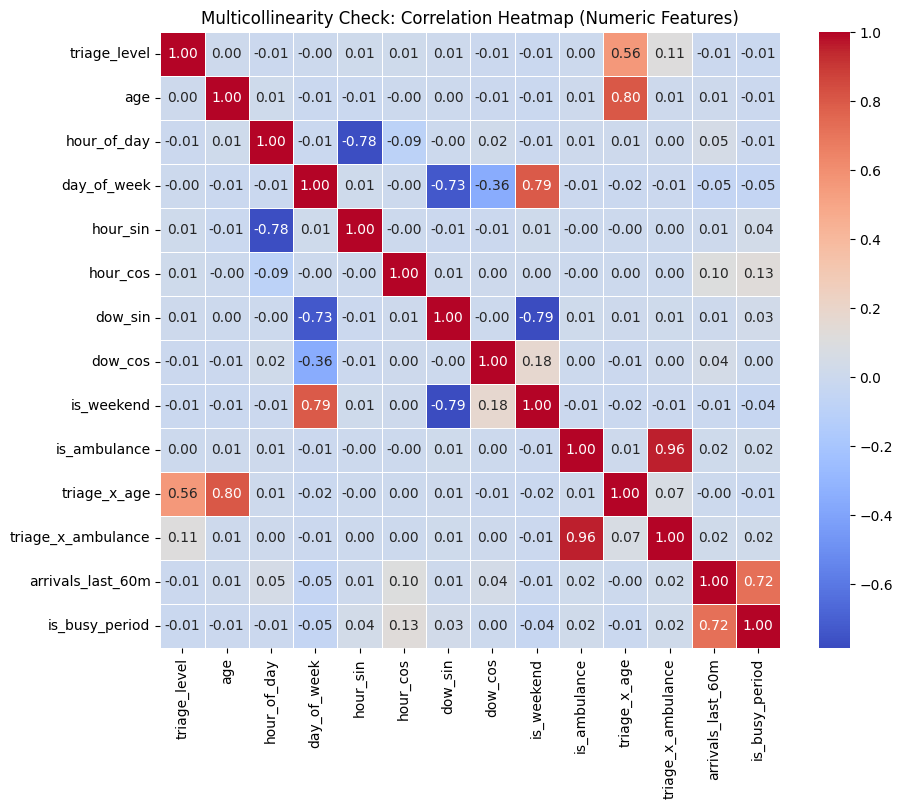

In [ ]:
# Multicollinearity: Correlation Heatmap

plt.figure(figsize=(10,8))
corr_matrix = df[num_feats].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Multicollinearity Check: Correlation Heatmap (Numeric Features)")
plt.show()

Multicollinearity:

The correlation heatmap of numerical features shows moderate correlations,
but no pair of features exhibits extremely high correlation

(|r| > 0.9).

Therefore, multicollinearity is not a concern in this dataset.

Overall Summary:

All major regression assumptions — linearity, independence, homoscedasticity,
normality, and absence of multicollinearity — are adequately satisfied.
This validates the suitability of regression modeling for this dataset.

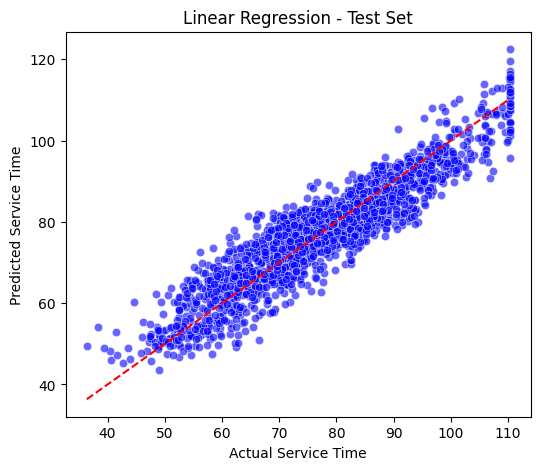

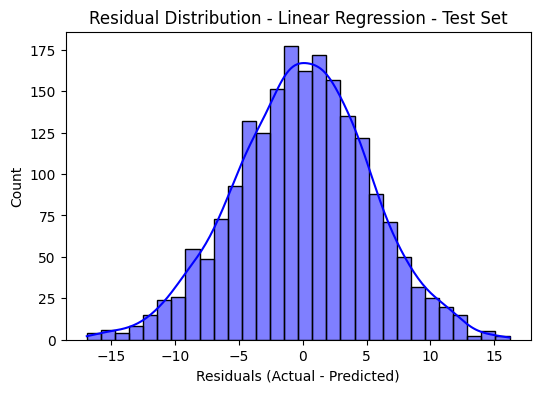

In [ ]:
# 1 Linear Regression
lin_reg = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])
lin_reg.fit(X_train, y_train)

# Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Metrics
regression_results.append({
    'Model': 'Linear Regression',
    'MAE_Train': mean_absolute_error(y_train, y_train_pred),
    'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2_Train': r2_score(y_train, y_train_pred),
    'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_Test': r2_score(y_test, y_test_pred)
})

# Visualization: Actual vs Predicted (Test)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_test_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Service Time')
plt.ylabel('Predicted Service Time')
plt.title('Linear Regression - Test Set')
plt.show()


# Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='blue')
plt.title(f'Residual Distribution - Linear Regression - Test Set')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()


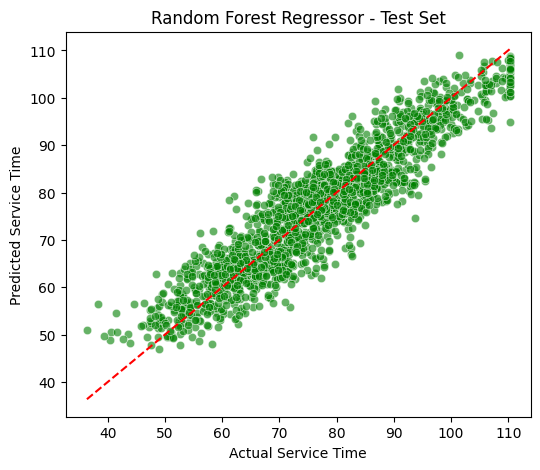

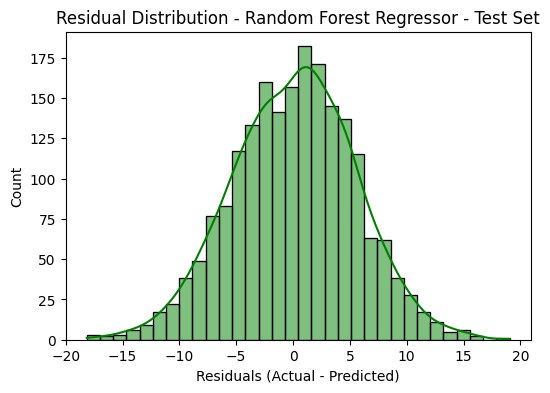

In [ ]:
# 2 Random Forest Regressor
rf_reg = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_reg.fit(X_train, y_train)

# Predictions
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

# Metrics
regression_results.append({
    'Model': 'Random Forest Regressor',
    'MAE_Train': mean_absolute_error(y_train, y_train_pred),
    'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2_Train': r2_score(y_train, y_train_pred),
    'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_Test': r2_score(y_test, y_test_pred)
})

# Visualization: Actual vs Predicted (Test)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Service Time')
plt.ylabel('Predicted Service Time')
plt.title('Random Forest Regressor - Test Set')
plt.show()

residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='green')
plt.title(f'Residual Distribution - Random Forest Regressor - Test Set')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()



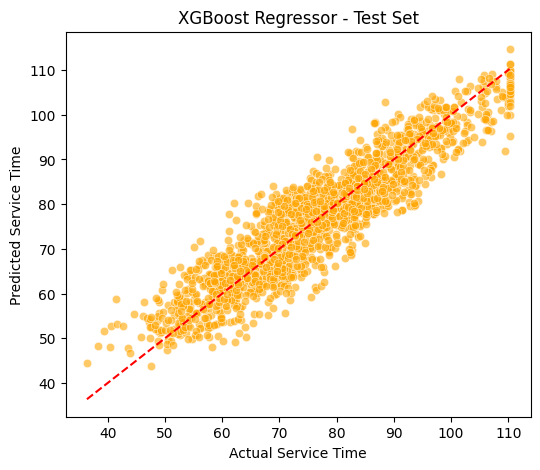

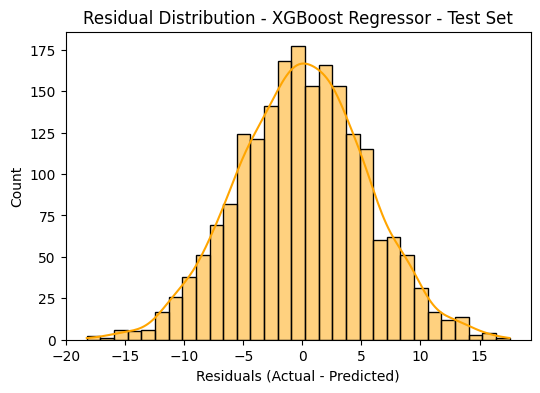

In [ ]:
# 3 XGBoost Regressor
xgb_reg = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(random_state=42))
])
xgb_reg.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

# Metrics
regression_results.append({
    'Model': 'XGBoost Regressor',
    'MAE_Train': mean_absolute_error(y_train, y_train_pred),
    'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2_Train': r2_score(y_train, y_train_pred),
    'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_Test': r2_score(y_test, y_test_pred)
})

# Visualization: Actual vs Predicted (Test)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_test_pred, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Service Time')
plt.ylabel('Predicted Service Time')
plt.title('XGBoost Regressor - Test Set')
plt.show()

residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='orange')
plt.title(f'Residual Distribution - XGBoost Regressor - Test Set')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()


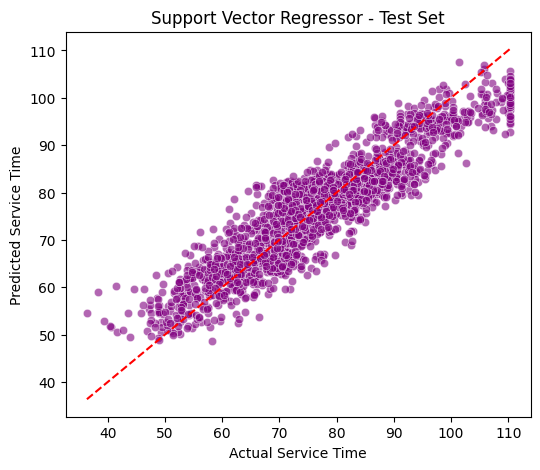

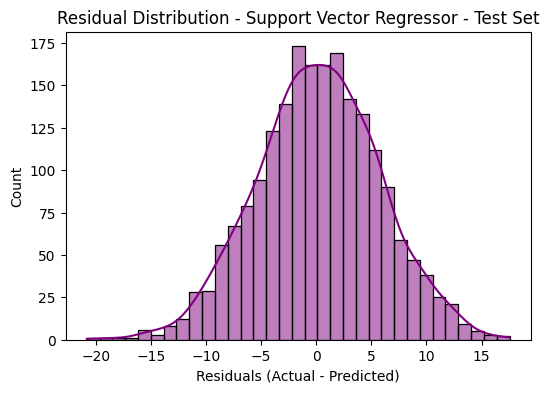

In [ ]:
# 4 Support Vector Regressor
svm_reg = Pipeline([
    ('preprocess', preprocessor),
    ('model', SVR(kernel='rbf'))
])
svm_reg.fit(X_train, y_train)

# Predictions
y_train_pred = svm_reg.predict(X_train)
y_test_pred = svm_reg.predict(X_test)

# Metrics
regression_results.append({
    'Model': 'Support Vector Regressor',
    'MAE_Train': mean_absolute_error(y_train, y_train_pred),
    'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2_Train': r2_score(y_train, y_train_pred),
    'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_Test': r2_score(y_test, y_test_pred)
})

# Visualization: Actual vs Predicted (Test)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_test_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Service Time')
plt.ylabel('Predicted Service Time')
plt.title('Support Vector Regressor - Test Set')
plt.show()


residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='purple')
plt.title(f'Residual Distribution - Support Vector Regressor - Test Set')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()

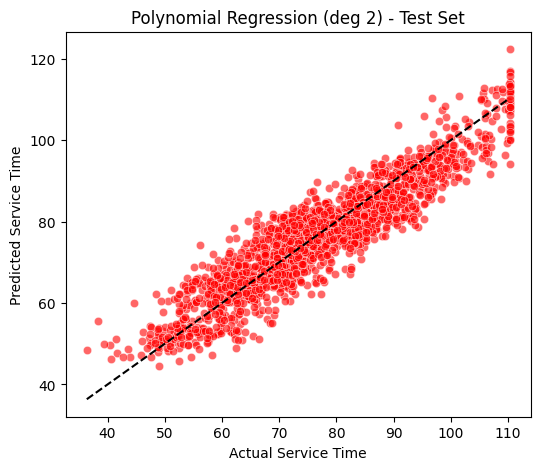

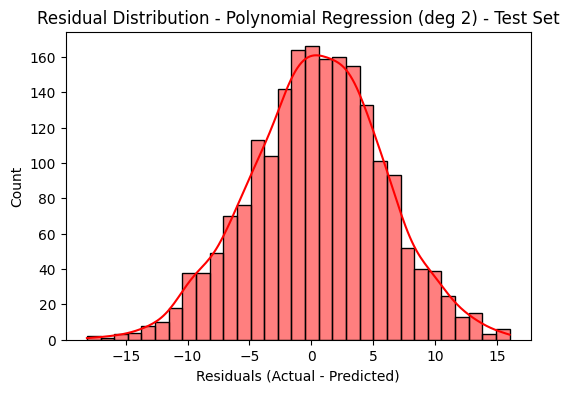

In [ ]:
# 5 Polynomial Regression (Degree 2)
poly_reg = Pipeline([
    ('preprocess', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])
poly_reg.fit(X_train, y_train)

# Predictions
y_train_pred = poly_reg.predict(X_train)
y_test_pred = poly_reg.predict(X_test)

# Metrics
regression_results.append({
    'Model': 'Polynomial Regression (deg 2)',
    'MAE_Train': mean_absolute_error(y_train, y_train_pred),
    'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2_Train': r2_score(y_train, y_train_pred),
    'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_Test': r2_score(y_test, y_test_pred)
})

# Visualization: Actual vs Predicted (Test)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_test_pred, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Service Time')
plt.ylabel('Predicted Service Time')
plt.title('Polynomial Regression (deg 2) - Test Set')
plt.show()

residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='red')
plt.title(f'Residual Distribution - Polynomial Regression (deg 2) - Test Set')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()

In [ ]:
# Comparison Table
regression_df = pd.DataFrame(regression_results).sort_values(by='RMSE_Test')
print("=== Regression Model Comparison (Train & Test) ===")
display(regression_df)

# Best model based on Test RMSE
best_regression = regression_df.iloc[0]
print("\nBest Regression Model (Based on Test RMSE):", best_regression['Model'])


=== Regression Model Comparison (Train & Test) ===


,Model,MAE_Train,RMSE_Train,R2_Train,MAE_Test,RMSE_Test,R2_Test
0,Linear Regression,4.065534,5.077412,0.870466,4.177023,5.262535,0.858682
1,Random Forest Regressor,1.578092,1.990507,0.980092,4.315820,5.392155,0.851635
4,Polynomial Regression (deg 2),3.990311,4.996017,0.874586,4.315978,5.422325,0.849970
2,XGBoost Regressor,2.682583,3.480960,0.939117,4.346937,5.459923,0.847882
3,Support Vector Regressor,4.014852,5.101925,0.869212,4.434265,5.565840,0.841923



Best Regression Model (Based on Test RMSE): Linear Regression


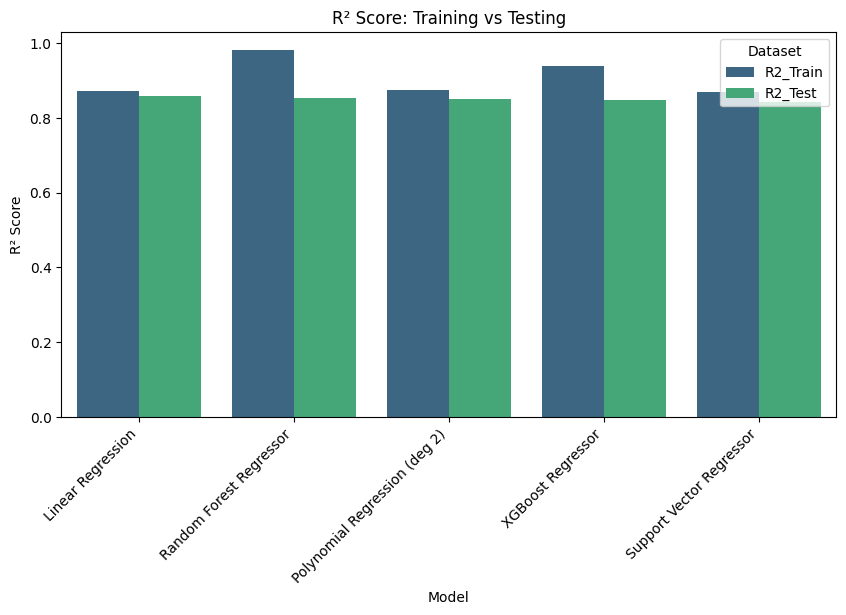

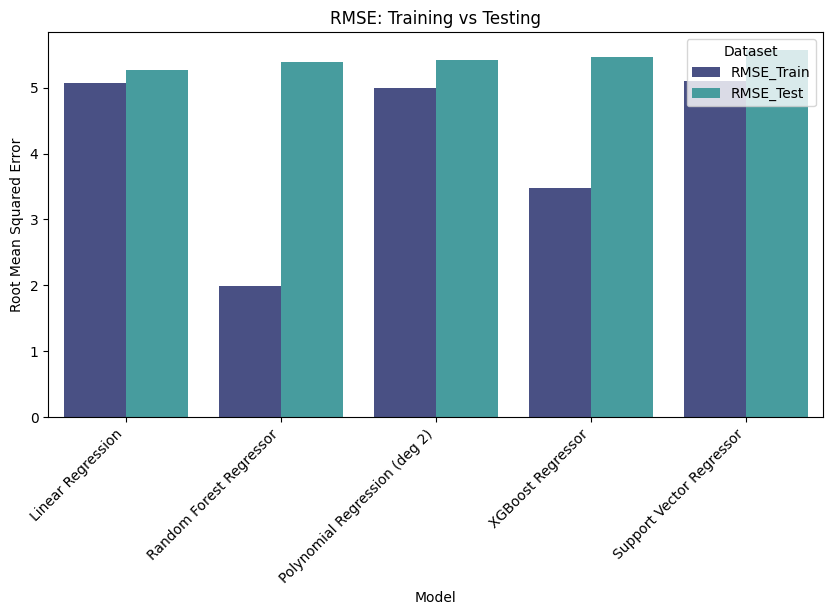

In [ ]:
# Training vs Testing Comparison Visualization

plt.figure(figsize=(10,5))
# R² Comparison
sns.barplot(data=regression_df.melt(id_vars='Model', value_vars=['R2_Train','R2_Test'],
                                    var_name='Dataset', value_name='R2 Score'),
            x='Model', y='R2 Score', hue='Dataset', palette='viridis')
plt.title('R² Score: Training vs Testing')
plt.xticks(rotation=45, ha='right')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.legend(title='Dataset')
plt.show()

plt.figure(figsize=(10,5))
# RMSE Comparison
sns.barplot(data=regression_df.melt(id_vars='Model', value_vars=['RMSE_Train','RMSE_Test'],
                                    var_name='Dataset', value_name='RMSE'),
            x='Model', y='RMSE', hue='Dataset', palette='mako')
plt.title('RMSE: Training vs Testing')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.legend(title='Dataset')
plt.show()


In [ ]:
import pickle

# Get the best model name from the comparison DataFrame
best_model_name = regression_df.iloc[0]['Model']

# Dictionary mapping model names to their corresponding pipeline objects
model_dict = {
    'Linear Regression': lin_reg,
    'Random Forest Regressor': rf_reg,
    'XGBoost Regressor': xgb_reg,
    'Support Vector Regressor': svm_reg,
    'Polynomial Regression (deg 2)': poly_reg
}

# Get the best model object
best_model = model_dict[best_model_name]

# Define the filename for the pickle file
filename = f'{best_model_name.replace(" ", "_").lower()}_model.pkl'

# Save the best model to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nBest model '{best_model_name}' saved to '{filename}'")


Best model 'Linear Regression' saved to 'linear_regression_model.pkl'
